# Modelagem Preditiva de Séries Temporais - Em Python

# <font color='blue'>Deep Learning - Recurrent Neural Networks (RNN)</font>

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Prevendo Séries Temporais com Stateful LSTMs 

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

## LSTMs Stateful x Stateless

Uma LSTM prevê com base na ativação da célula de memória no timestep anterior. Você então deve copiar essa ativação entre lotes? Ou você define todas as ativações como zeros? Isso é o que distingue uma LSTM com estado (stateful) e sem estado (stateless). Portanto, o estado refere-se a ativações de neurônios, não aos parâmetros (que são mantidos em ambos os casos).

Quando devemos usar LSTMs em modo stateful ou stateless?

Depende se você deseja que as previsões no lote n dependam do estado no lote n-1. Por exemplo, na modelagem de linguagem, os lotes sucessivos são trocas sucessivas de texto, por isso faz sentido manter o estado. Mas se você sabe que os lotes sucessivos não estão relacionados entre si, talvez seja mais sensato redefinir o estado.

"Stateless" é como redefinir a LSTM para um "estado inicial" a cada novo lote, e 'stateful' significa que você continua de onde você está. Em ambos os casos, a LSTM está aprendendo porque as probabilidades de transição são atualizadas.

A LSTM stateless deve ser usada se as instâncias de diferentes lotes forem independentes, por exemplo, ao modelar padrões de nível de sentença e cada instância for uma frase - o estado deve ser redefinido para "início de sentença" para cada nova instância. LSTM stateful é mais útil se houver continuidade entre a iª instância de todos os lotes, por exemplo, ao modelar padrões de nível de documento (sem redefinir os limites das orações) ou séries temporais. Neste caso, a i-ésima instância de cada lote deve ser as frases consequentes do i-ésimo documento.

Memória Entre Batches
A rede LSTM possui memória que é capaz de se lembrar através de sequências longas. Normalmente, o estado dentro da rede é reiniciado após cada lote de treinamento ao chamar modelo.fit(), bem como cada chamada para model.predict() ou model.evaluate(). Nós podemos controlar quando o estado interno da rede LSTM é apagado no Keras, fazendo a camada LSTM com estado (usando o parâmetro stateful). Isso significa que podemos criar estado em toda a sequência de treinamento e até mesmo manter esse estado, se necessário, para fazer previsões.

Esta técnica exige que os dados de treino não sejam "shuffled" durante o treinamento da rede. Também requer reinicialização explícita do estado da rede após cada exposição aos dados de treinamento (epoch) com chamadas para model.reset_states(). Isso significa que devemos criar nosso próprio ciclo externo de épocas e dentro de cada epoch, fazer as chamadas a model.fit() e model.reset().

O módulo reset_states() limpa apenas os estados ocultos da sua rede. Vale a pena mencionar que, dependendo se a opção stateful = True foi configurada em sua rede - o comportamento desta função pode ser diferente. Se não estiver configurado - todos os estados são reiniciados automaticamente após cada cálculo de lote em sua rede (por exemplo, depois de chamar model.fit(), model.predict() e model.evaluate()). Caso contrário - você deve chamar reset_states() toda vez, quando quiser fazer chamadas de modelo consecutivas independentes.

Stateful = True geralmente é usado quando você deseja tratar lotes consecutivos como entradas consecutivas. Neste caso, o modelo está tratando lotes consecutivos como se estivessem no mesmo batch.

Quando a camada LSTM for criada, o parâmetro stateful = True deve ser definido e ao invés de especificar a dimensão de entrada, devemos informar o número de amostras em um batch, o número de time steps na amostra e o número de features no time step configurando o parâmetro batch_input_shape. Nossa camada LSTM ficará assim:

model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))

O mesmo batch_size deve ser usado mais tarde para fazer as previsões: model.predict(trainX, batch_size=batch_size)

Configurar uma RNN com stateful = True significa que os estados para as amostras de cada lote serão reutilizados como estados iniciais para as amostras no próximo lote.

<a id = 'etapa1'></a>
## Etapa 1: Conjunto de dados

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

<a id='etapa2'></a>
## Etapa 2: Importar as Bibliotecas

In [1]:
# Importa TF2
import tensorflow as tf
tf.__version__

'2.10.0'

In [2]:
# Imports
import math
import numpy
import pandas as pd
import os
import io
import requests

from pandas.tseries.offsets import DateOffset
from time import time
from datetime import datetime

# Importa Keras TF2
from tensorflow import keras   
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
# Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
# Define o PATH onde estão os dados
save_path = "./save"

# Random seed 
numpy.random.seed(7)

look_back = 10

Clique no título da etapa para acessá-la diretamente.

* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

<a id='etapa3'></a>
## Etapa 3: Criar o Modelo

In [5]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)
dataframe

,Data,Broker,Service_name,Service_class,Programa,Quantidade
0,2021-11-27,ETB160,DETRAN,SDGX,NSDGX047,6
1,2021-11-27,ETB160,DETRAN,SDGX,NSDAKG12,1
2,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ08,1
3,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ07,1
4,2021-11-27,ETB160,DETRAN,SDGX,NSDGX414,1
...,...,...,...,...,...,...
71289,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX500,217
71290,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX495,9
71291,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX469,121
71292,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX467,12


In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71294 entries, 0 to 71293
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Data           71294 non-null  datetime64[ns]
 1   Broker         71294 non-null  object        
 2   Service_name   71294 non-null  object        
 3   Service_class  71294 non-null  object        
 4   Programa       71294 non-null  object        
 5   Quantidade     71294 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.3+ MB


In [7]:
# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)
datasetfull

,Data,Quantidade
0,2021-11-27,96
1,2021-11-26,82
2,2021-11-25,50
3,2021-11-24,50
4,2021-11-23,100
...,...,...
572,2022-10-21,78
573,2022-10-22,65
574,2022-10-24,79
575,2022-10-25,176


In [8]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()
datasetfull

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0
...,...
2022-10-21,207.0
2022-10-22,22.0
2022-10-23,50.5


In [9]:
datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

In [10]:
# Dados
datasetfull

array([[162.      ],
       [ 66.      ],
       [ 58.      ],
       [ 44.      ],
       [ 83.      ],
       [ 84.5     ],
       [ 86.      ],
       [ 87.      ],
       [ 88.      ],
       [ 63.      ],
       [212.      ],
       [ 64.      ],
       [ 90.5     ],
       [117.      ],
       [ 50.      ],
       [115.      ],
       [ 54.      ],
       [ 92.      ],
       [124.      ],
       [103.333336],
       [ 82.666664],
       [ 62.      ],
       [106.      ],
       [ 33.      ],
       [120.      ],
       [107.      ],
       [145.5     ],
       [184.      ],
       [100.      ],
       [ 50.      ],
       [ 50.      ],
       [ 82.      ],
       [ 96.      ],
       [ 83.      ],
       [ 70.      ],
       [ 98.      ],
       [  4.      ],
       [111.      ],
       [194.      ],
       [  3.      ],
       [ 48.5     ],
       [ 94.      ],
       [ 95.      ],
       [135.      ],
       [ 14.      ],
       [  4.      ],
       [215.      ],
       [109. 

In [11]:
# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

In [12]:
# Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. Podemos normalizar facilmente o conjunto de dados usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

In [13]:
# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [14]:
dataset.shape

(273, 1)

In [15]:
train.shape

(182, 1)

In [16]:
valid.shape

(91, 1)

In [17]:
test.shape

(92, 1)

In [18]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [19]:
# Cria o modelo LSTM

# Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
for i in range(200):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 2, shuffle = False)
    model.reset_states()
    
current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 22:27:27
171/171 - 6s - loss: 0.0419 - 6s/epoch - 32ms/step
171/171 - 1s - loss: 0.0359 - 1s/epoch - 7ms/step
171/171 - 1s - loss: 0.0357 - 1s/epoch - 6ms/step
171/171 - 1s - loss: 0.0355 - 968ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0353 - 976ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0352 - 1s/epoch - 6ms/step
171/171 - 1s - loss: 0.0351 - 1s/epoch - 7ms/step
171/171 - 1s - loss: 0.0349 - 912ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0348 - 940ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0347 - 934ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0346 - 929ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0345 - 1s/epoch - 6ms/step
171/171 - 1s - loss: 0.0344 - 1s/epoch - 7ms/step
171/171 - 1s - loss: 0.0343 - 970ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0342 - 957ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0342 - 962ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0341 - 972ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0340 - 961ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0339 - 962ms/epoc

171/171 - 1s - loss: 0.0309 - 940ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0307 - 934ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0304 - 935ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0305 - 923ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0307 - 917ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0307 - 929ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0305 - 921ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0303 - 924ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0305 - 940ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0306 - 915ms/epoch - 5ms/step
171/171 - 1s - loss: 0.0306 - 943ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0303 - 1s/epoch - 6ms/step
171/171 - 1s - loss: 0.0302 - 1s/epoch - 6ms/step
171/171 - 1s - loss: 0.0303 - 1s/epoch - 7ms/step
171/171 - 1s - loss: 0.0305 - 1s/epoch - 6ms/step
171/171 - 1s - loss: 0.0302 - 1s/epoch - 6ms/step
171/171 - 1s - loss: 0.0301 - 1s/epoch - 6ms/step
171/171 - 1s - loss: 0.0302 - 976ms/epoch - 6ms/step
171/171 - 1s - loss: 0.0301 - 1s/epoch - 6ms/step
171/171 - 1s -

In [20]:
# Salvando a rede inteira no formato HDF5 (salvando todos os componentes da rede, incluindo os pesos)
model.save(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Stateful.h5"))

<a id='etapa4'></a>
## Etapa 4: Testar o Modelo

## Agora recarregamos o modelo para realizamos uma previsão.

In [21]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [22]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Stateful.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 4)                    96        
                                                                 
 dense (Dense)               (1, 1)                    5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Previsões
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)

80/80 [==============================] - 0s 3ms/step


In [24]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])

In [25]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 53.4697 RMSE
Score em Validação: 66.2286 RMSE


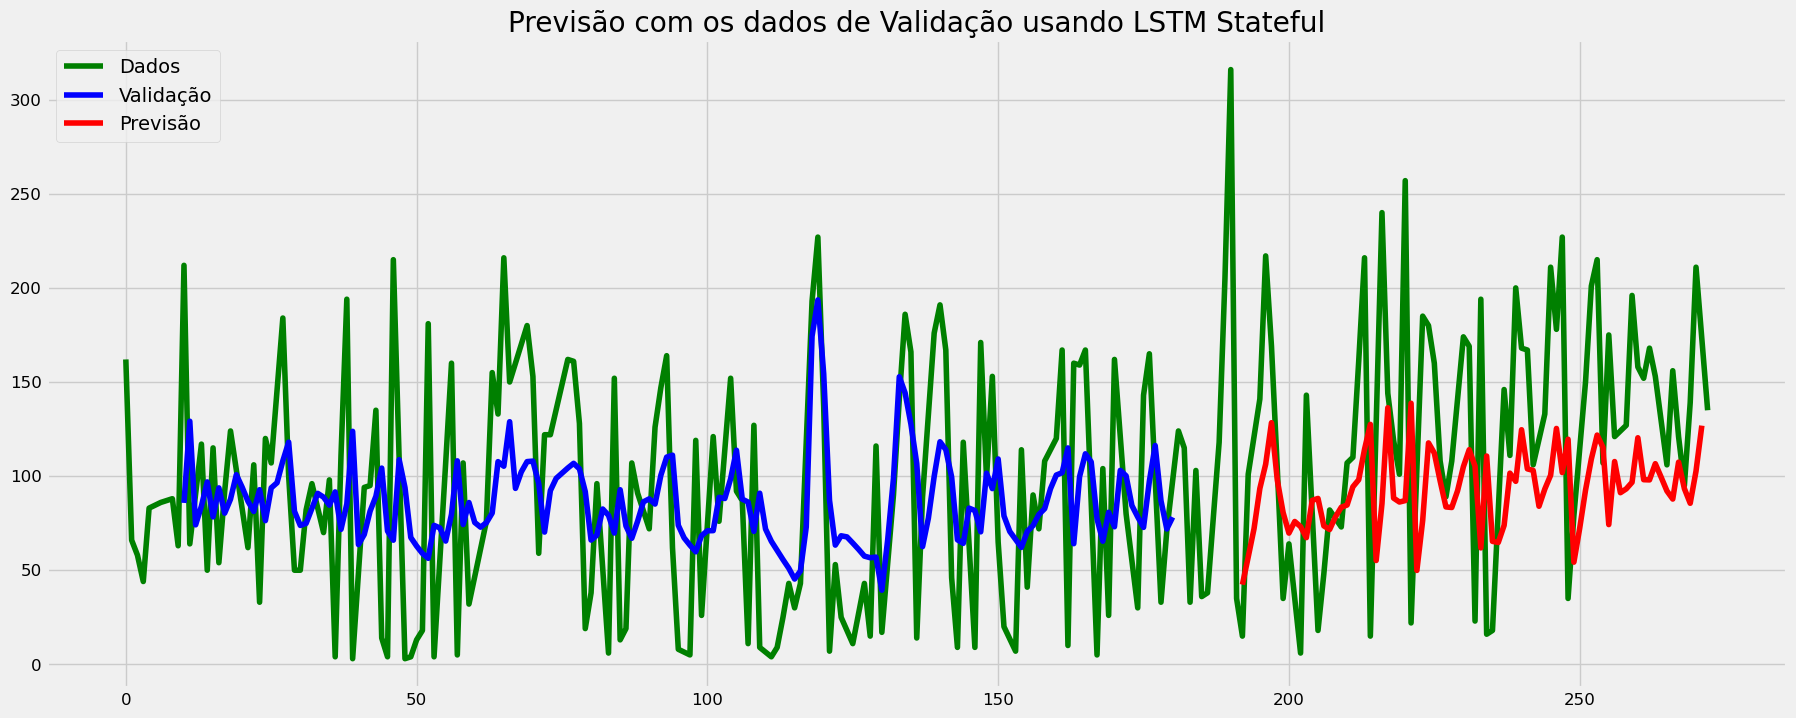

In [26]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação usando LSTM Stateful") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, color = 'blue', label = 'Validação')
plt.plot(validPredictPlot, color = 'red', label = 'Previsão')
plt.legend(loc = 'upper left') 
plt.show()

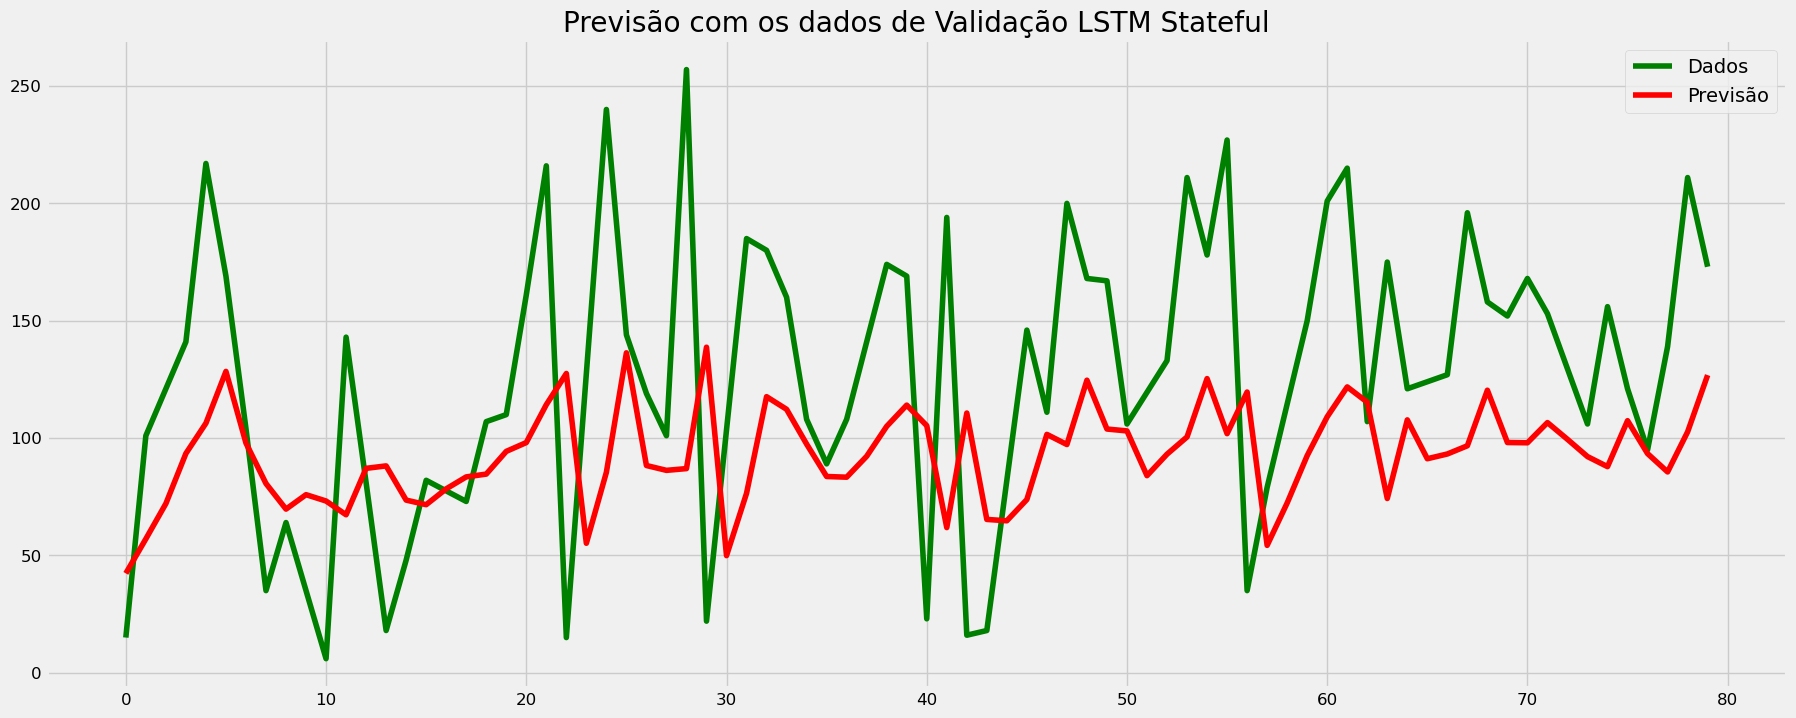

In [27]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação LSTM Stateful") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

In [28]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [29]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Stateful.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 4)                    96        
                                                                 
 dense (Dense)               (1, 1)                    5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Previsões com dados de Teste
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size = batch_size)

81/81 [==============================] - 0s 4ms/step


In [31]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scalerTeste.inverse_transform(testPredict)
testY = scalerTeste.inverse_transform([testY])

In [32]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 53.4697 RMSE
Score em Validação: 66.2286 RMSE
Score em Teste: 83.3471 RMSE


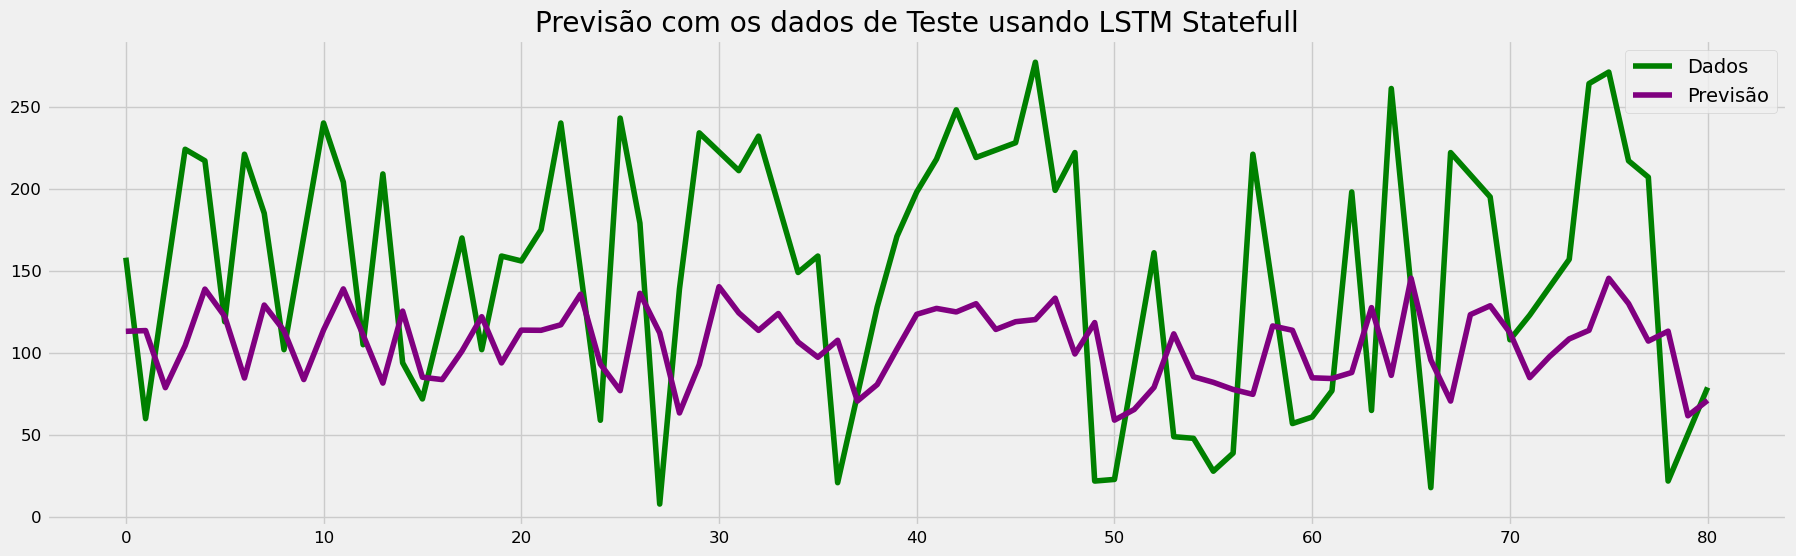

In [33]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Statefull") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

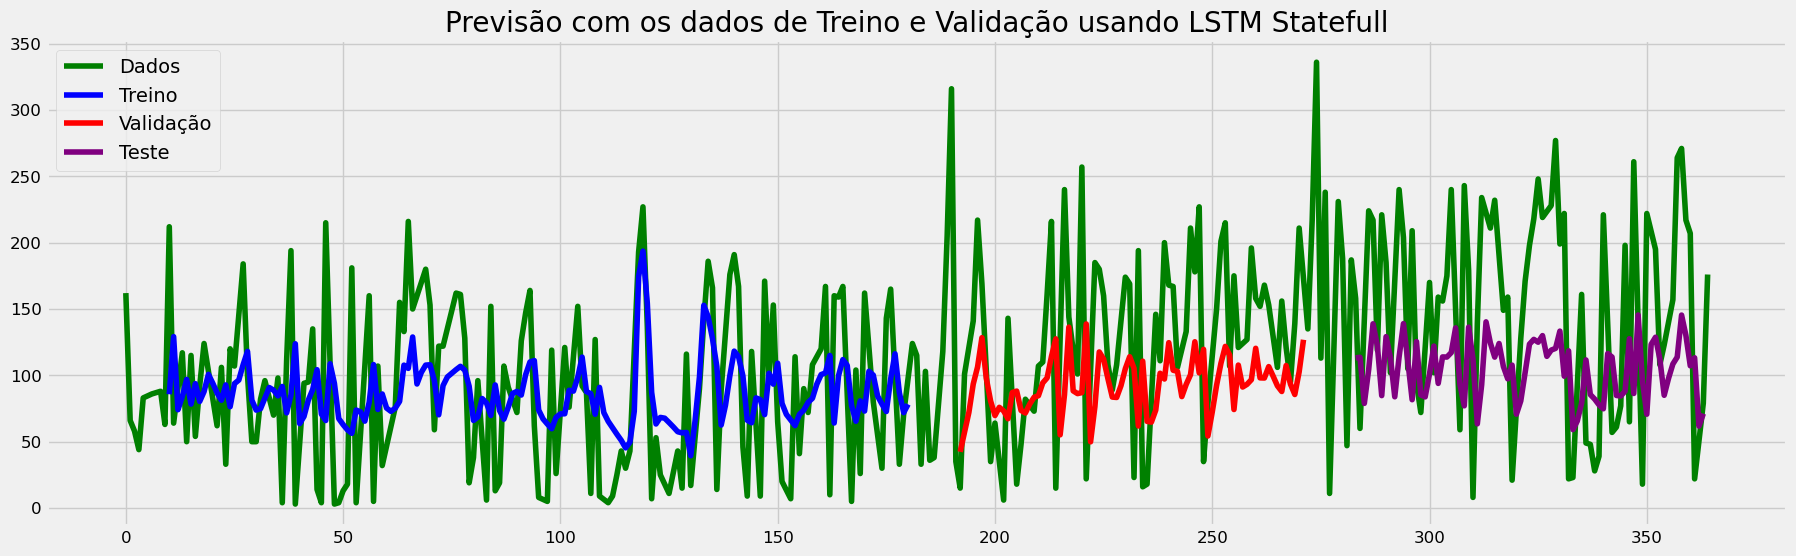

In [34]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(datasetfull)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict             

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*3)+2:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Statefull") 
#plt.plot(datasetfull, label = 'Dados', color = 'green')
plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

<a id='etapa5'></a>
## Etapa 5: Realizar as Previsões

## Vamos fazer o Forecasting para 82 dias de previsão

In [35]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull.drop(columns=['Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

# Refinamos os dados para o gráfico da série original
# A variável Quantidade é nossa variável target 
target = datasetfull['Quantidade']
raw_values = target.values

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX1, trainY = create_dataset(train, look_back)
validX1, validY = create_dataset(valid, look_back)
testX1, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
trainX = numpy.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
validX = numpy.reshape(validX1, (validX1.shape[0], validX1.shape[1], 1))
testX = numpy.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

In [36]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Stateful.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 4)                    96        
                                                                 
 dense (Dense)               (1, 1)                    5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, look_back, 1)
    yhat = model.predict(X)
    yhat1 = scaler.inverse_transform(yhat)
    return yhat1[0,0]

In [38]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões

for i in range(len(testX1)):   
   
    # Ajusta o shape dos dados de teste
    X, y = testX1[i], testY[i]
    
    # Previsão

    yhat = forecast_lstm(model, X)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(testX1) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

1/1 [==============================] - 0s 438ms/step
Mês = 1, Valor Previsto = 103.354858, Valor Esperado = 96.000000
1/1 [==============================] - 0s 27ms/step
Mês = 2, Valor Previsto = 103.786163, Valor Esperado = 51.000000
1/1 [==============================] - 0s 28ms/step
Mês = 3, Valor Previsto = 70.625099, Valor Esperado = 6.000000
1/1 [==============================] - 0s 27ms/step
Mês = 4, Valor Previsto = 95.027283, Valor Esperado = 152.000000
1/1 [==============================] - 0s 31ms/step
Mês = 5, Valor Previsto = 127.883202, Valor Esperado = 13.000000
1/1 [==============================] - 0s 29ms/step
Mês = 6, Valor Previsto = 112.062782, Valor Esperado = 19.000000
1/1 [==============================] - 0s 29ms/step
Mês = 7, Valor Previsto = 76.226303, Valor Esperado = 107.000000
1/1 [==============================] - 0s 27ms/step
Mês = 8, Valor Previsto = 118.626038, Valor Esperado = 91.000000
1/1 [==============================] - 0s 31ms/step
Mês = 9, Valo

1/1 [==============================] - 0s 27ms/step
Mês = 71, Valor Previsto = 102.576309, Valor Esperado = 20.000000
1/1 [==============================] - 0s 26ms/step
Mês = 72, Valor Previsto = 76.451294, Valor Esperado = 13.500000
1/1 [==============================] - 0s 25ms/step
Mês = 73, Valor Previsto = 88.618477, Valor Esperado = 7.000000
1/1 [==============================] - 0s 26ms/step
Mês = 74, Valor Previsto = 98.949753, Valor Esperado = 114.000000
1/1 [==============================] - 0s 26ms/step
Mês = 75, Valor Previsto = 103.940643, Valor Esperado = 41.000000
1/1 [==============================] - 0s 28ms/step
Mês = 76, Valor Previsto = 134.161484, Valor Esperado = 90.000000
1/1 [==============================] - 0s 27ms/step
Mês = 77, Valor Previsto = 119.473198, Valor Esperado = 72.000000
1/1 [==============================] - 0s 28ms/step
Mês = 78, Valor Previsto = 97.686050, Valor Esperado = 108.000000
1/1 [==============================] - 0s 27ms/step
Mês = 7

In [39]:
# Última data da série
target.index[-1]

Timestamp('2022-10-25 00:00:00', freq='D')

In [40]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 82)]

In [41]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [42]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [43]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,Quantidade
2022-10-26,NaN
2022-10-27,NaN
2022-10-28,NaN
2022-10-29,NaN
2022-10-30,NaN
...,...
2023-01-10,NaN
2023-01-11,NaN
2023-01-12,NaN
2023-01-13,NaN


In [44]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(testPredict,
                          index = data_futuras.index, columns = ['Prediction'])

In [45]:
df_predict

,Prediction
2022-10-26,113.164200
2022-10-27,113.616173
2022-10-28,78.865921
2022-10-29,104.437538
2022-10-30,138.868027
...,...
2023-01-10,130.054977
2023-01-11,107.223724
2023-01-12,113.248077
2023-01-13,61.744343


In [46]:
# Concatenamos a série original com os valores de forecasting de 82 dias além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [47]:
df_forecasting.to_csv(r'./CSV/PipaMainframe_Forecasting_Stateful.csv', index = False)

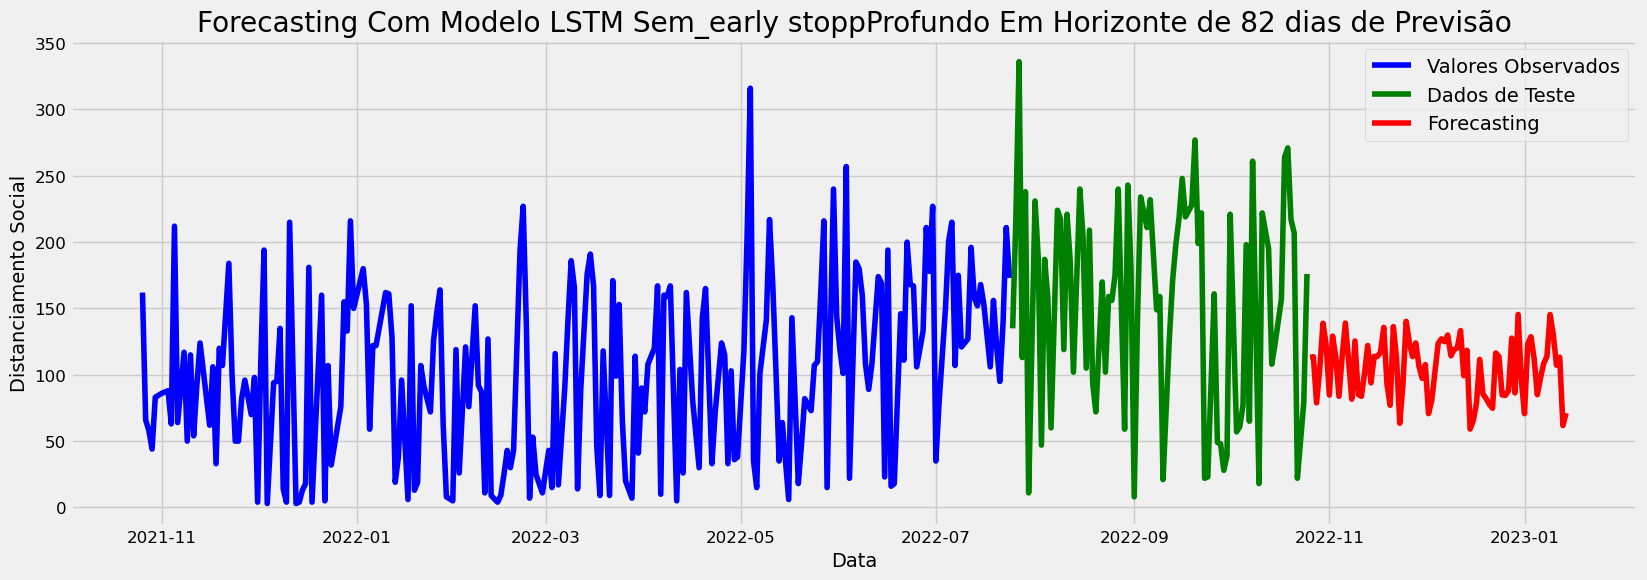

In [48]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index[0:272], target.values[0:272], label = 'Valores Observados', color = 'Blue')
plt.plot(target.index[272:], target.values[272:], label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Sem_early stoppProfundo Em Horizonte de 82 dias de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim